In [1]:
import sys
sys.path.insert(1, '../..')

import torch
import torch.nn as nn
import random
import pandas as pd
import numpy as np
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from library.evaluation import ConfusionMatrix

torch.manual_seed(33)
np.random.seed(33)
random.seed(33)

dataset_name = "Twitter15-TF"
unique_name = "RoBERTa_Finetuned"

c:\Users\msi_b\anaconda3\envs\pytorch-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
vectors = np.loadtxt("../../data/vectors/Twitter15-TF_RoBERTa_base_finetuned_vectors.txt", delimiter=",")
first = vectors[0]
vectors.shape

(742, 768)

In [3]:
data = pd.read_csv("../../data/processed/twitter15-tf_dataset.csv", lineterminator="\n")
data.head()

,tweet_id,tweet_text,label,tvt2,tvt2_1,tvt2_2,tvt2_3
0,551099691702956032,rip elly may clampett: so sad to learn #beverl...,True,training,validation,training,training
1,514106273852174337,just in: missing afghan soldiers found trying ...,True,training,training,training,testting
2,495366618818830336,#riphulkhogan my heart is ripping like your sh...,False,training,testting,validation,training
3,532206910796468224,a chick-fil-a manager allegedly banned this hi...,False,validation,training,training,training
4,560187970389819392,islamic tribunal using sharia law in texas has...,False,validation,training,validation,validation


In [4]:
labels_str = data['label'].unique().tolist()
labels_str

[True, False]

In [5]:
labels = []
for i, d in data.iterrows():
    lab = labels_str.index(d['label'])
    labels.append(lab)
labels[:10]

[0, 0, 1, 1, 1, 1, 1, 1, 0, 1]

In [6]:
train_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_vectors = np.array([vectors[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

train_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'training'])
val_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'validation'])
test_labels = np.array([labels[i] for i, d in data.iterrows() if d['tvt2'] == 'testting'])

In [7]:
print(train_vectors.shape)
print(val_vectors.shape)
print(test_vectors.shape)

print(train_labels.shape)
print(val_labels.shape)
print(test_labels.shape)

(497, 768)
(152, 768)
(93, 768)
(497,)
(152,)
(93,)


In [8]:
for_cv_vectors = np.concatenate((train_vectors, val_vectors))
train_vectors = None
val_vectors = None
print(for_cv_vectors.shape)

(649, 768)


In [9]:
for_cv_labels = np.concatenate((train_labels, val_labels))
train_labels = None
val_labels = None
print(for_cv_labels.shape)

(649,)


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes):
        super(BasicBlock, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.bn2(self.lin2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(Bottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm1d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm1d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm1d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, n_input=768, num_classes=1):
        super(ResNet, self).__init__()
        self.in_planes = 512

        self.lin1 = nn.Linear(n_input, self.in_planes)
        self.bn1 = nn.BatchNorm1d(self.in_planes)
        self.layer1 = self._make_layer(block, 512, num_blocks[0])
        self.layer2 = self._make_layer(block, 256, num_blocks[1])
        self.layer3 = self._make_layer(block, 128, num_blocks[2])
        self.layer4 = self._make_layer(block, 64, num_blocks[3])
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks):
        strides = [1] * num_blocks
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet10(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [1, 1, 1, 1], n_input, n_output)

    
def ResNet18(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [2, 2, 2, 2], n_input, n_output)


def ResNet34(n_input=768, n_output=1, block=BasicBlock):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet50(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 6, 3], n_input, n_output)


def ResNet101(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 4, 23, 3], n_input, n_output)


def ResNet152(n_input=768, n_output=1, block=Bottleneck):
    return ResNet(block, [3, 8, 36, 3], n_input, n_output)

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class CNNBasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(CNNBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes):
        super(CNNBottleneck, self).__init__()
        self.lin1 = nn.Linear(in_planes, planes)
        self.bn1 = nn.BatchNorm2d(planes)
        self.lin2 = nn.Linear(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.lin3 = nn.Linear(planes, planes)
        self.bn3 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Linear(in_planes, planes),
                nn.BatchNorm1d(planes)
            )

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.lin1(x)), 0.1)
        out = F.leaky_relu(self.bn2(self.lin2(out)), 0.1)
        out = self.bn3(self.lin3(out))
        out += self.shortcut(x)
        out = F.leaky_relu(out, 0.1)
        return out


class CNNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1):
        super(CNNResNet, self).__init__()
        self.in_planes = 24

        self.conv1 = nn.Conv2d(1, 24, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(24)
        self.layer1 = self._make_layer(block, 24, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 48, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 64, num_blocks[3], stride=2)
        self.linear = nn.Linear(64 * 24 * 32, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.leaky_relu(self.bn1(self.conv1(x)), 0.1)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def CNNResNet10(n_output: int):
    return CNNResNet(CNNBasicBlock, [1, 1, 1, 1], n_output)

    
def CNNResNet18(n_output: int):
    return CNNResNet(CNNBasicBlock, [2, 2, 2, 2], n_output)


def CNNResNet34(n_output: int):
    return CNNResNet(CNNBasicBlock, [3, 4, 6, 3], n_output)


def CNNResNet50(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 6, 3], n_output)


def CNNResNet101(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 4, 23, 3], n_output)


def CNNResNet152(n_output: int):
    return CNNResNet(CNNBottleneck, [3, 8, 36, 3], n_output)

In [12]:
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
from typing import Callable


class ResNetClassifier(nn.Module):
    def __init__(self,
        model,
        n_input: int,
        n_output: int = 1,
        criterion: Callable = nn.BCELoss,
        n_features: int = 4,
        lr: float = 0.0002,
        beta1: float = 0.5,
        device: str = None,
        model_type: str = "mlp"
    ):
        super(ResNetClassifier, self).__init__()
        self.model = model
        self.model_type = model_type
        self.criterion = criterion()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr, betas=(beta1, 0.999))

        if not device or device not in ['cpu', 'cuda']:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        else:
            self.device = device

        self.model = self.model.to(self.device)
        if self.device == 'cuda':
            self.model = torch.nn.DataParallel(self.model)
            cudnn.benchmark = True

    def forward(self, input):
        x = self.model(input)
        return x
    
    def load_pretrained(self, filepath: str, key: str = "net", is_parallel: bool = False):
        checkpoint = torch.load(filepath)
        if is_parallel:
            self.model = torch.nn.DataParallel(self.model)
        self.model.load_state_dict(checkpoint[key], strict=False)
    
    def save_model(self, saves: str):
        print(f"Saving model...")
        state = {
            'net': self.model.state_dict()
        }
        if not os.path.isdir('models'):
            os.mkdir('models')
        torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
    
    def train_eval(self,
        train_x, train_y,
        test_x, test_y,
        n_iter: int = 100,
        batch_size: int = 128,
        saves: str = None,
        fold: int = None
    ):
        trainset = torch.utils.data.TensorDataset(train_x, train_y) # create your datset
        trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size) # create your dataloader

        testset = torch.utils.data.TensorDataset(test_x, test_y) # create your datset
        testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size) # create your dataloader

        train_accs = []
        train_losses = []
        test_accs = []
        test_losses = []

        print(f"Using {self.device}")
        best_acc = 0
        current_loss = 1000
        best_test_acc = 0
        epoch = 0
        start_time = time.time()
        results = {}
        while True:
            epoch += 1
            self.model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            for idx, (inputs, targets) in enumerate(trainloader):
                self.optimizer.zero_grad()
                inputs, targets = inputs.to(self.device), targets.to(self.device)

                if self.model_type == "cnn":
                    outputs = self.model(inputs.unsqueeze(1))
                elif self.model_type == "mlp":
                    outputs = self.model(inputs)

                loss = self.criterion(outputs, targets.long())
                loss.backward()
                self.optimizer.step()

                _, predicted = outputs.max(1)
                train_loss += loss.item()
                train_total += targets.size(0)
                train_correct += predicted.eq(targets).sum().item()


            train_acc=100.*train_correct/train_total
            train_accs.append(train_acc)
            train_losses.append(train_loss)

            self.model.eval()
            test_loss = 0
            test_correct = 0
            test_total = 0
            # test_acc = 0
            with torch.no_grad():
                for idx, (inputs, targets) in enumerate(testloader):
                    inputs, targets = inputs.to(self.device), targets.to(self.device)
                    
                    if self.model_type == 'mlp':
                        outputs = self.model(inputs)
                    else:
    #                     outputs = self.model(inputs.reshape(inputs.shape[0], 1, 24, 32))
                        outputs = self.model(inputs.unsqueeze(1))

                    loss = self.criterion(outputs, targets.long())
                    test_loss += loss.item()

                    _, predicted = outputs.max(1)
                    test_total += targets.size(0)
                    test_correct += predicted.eq(targets).sum().item()
                    # if self.model_type == 'mlp':
                    #     preds = self.predict(test_x)
                    # else:
                    #     preds = self.predict(test_x.reshape(test_x.shape[0], 1, 24, 32))
                    # conf_mat = ConfusionMatrix(
                    #     labels=np.array([[1 if j == v else 0 for j in range(len(labels_str))] for v in test_y]),
                    #     predictions=np.array([[1 if j == p else 0 for j in range(len(labels_str))] for p in preds.cpu().numpy()]),
                    #     binary=False
                    # )
                    # conf_mat.evaluate(logs=False)
                    # test_acc = conf_mat.accuracy
            test_acc=100.*test_correct/test_total
            test_accs.append(test_acc)
            test_losses.append(test_loss)
            
            if (epoch) % round(n_iter/20) == 0:
                print(f"-- Epoch {epoch}, Train_Accuracy : {train_acc}, Validation Accuracy : {test_acc}, Train Loss : {train_loss}, Validation Loss : {test_loss}")

            # Save checkpoint.
#             if saves and test_loss < best_loss:
#                 print(f"Saving after new best loss : {test_loss}")
#                 best_loss = test_loss
            if saves and test_acc > best_test_acc:
                print(f"Saving after new best accuracy : {test_acc}")
                best_test_acc = test_acc

                state = {
                    'net': self.model.state_dict(),
                }
                if not os.path.isdir('models'):
                    os.mkdir('models')
                torch.save(state, f"../../data/models/cross-validation/{saves}.pth")
            
            if epoch >= n_iter:
                break

         # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_accs))], train_accs, label='Training Accuracy')
        ax2.plot([i for i in range(len(test_accs))], test_accs, label='Validation Accuracy')
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Accuracy Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Accuracy/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Accuracy_Graph_Fold{fold}.png")
        
        # visualizing accuracy over epoch
        fig, ax2 = plt.subplots(1)
        plt.subplots_adjust(hspace=1.5, wspace=0.4)
        ax2.plot([i for i in range(len(train_losses))], train_losses, label='Training Loss')
        ax2.plot([i for i in range(len(test_losses))], test_losses, label='Validation Loss')
        ax2.set_ylabel('Loss')
        ax2.set_xlabel('Epoch')
        # ax2.set_xlim(0, len(train_losses))
        # ax2.set_ylim(min([min(train_losses), min(test_losses)])*0.1, max([max(train_losses), max(test_losses)]))
        ax2.title.set_text(f"Training and Validation Loss Over Time (epoch) Fold {fold}")
        ax2.legend(loc='lower right')

        plt.show()
        fig.savefig(f"../../Grafik/Loss/Cross-Validation/{dataset_name}_ResNet10_CNN_{unique_name}_Loss_Graph_Fold{fold}.png")
    
    def predict(self, input_x):
        self.model.eval()
        with torch.no_grad():
            preds = self.model(torch.Tensor(input_x))
            preds = torch.log_softmax(preds, dim = 1)
            _, preds = torch.max(preds, dim = 1)
            return preds

In [13]:
from sklearn.model_selection import StratifiedKFold

kf = StratifiedKFold(n_splits=5)

--- FOLD 1 ----
Multiclass Classification Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1
Using cuda
Saving after new best accuracy : 90.0
Saving after new best accuracy : 93.84615384615384
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.002419175063550938, Validation Loss : 0.002921337028965354
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0007608063933730591, Validation Loss : 0.0018178451573476195
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00038944659172557294, Validation Loss : 0.0014139943523332477
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00024135833700711373, Validation Loss : 0.0011929345782846212
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00016580353258177638, Validation Loss : 0.001045740908011794
-- Epoch 300, Train_Accuracy : 100.0, Validation Accura

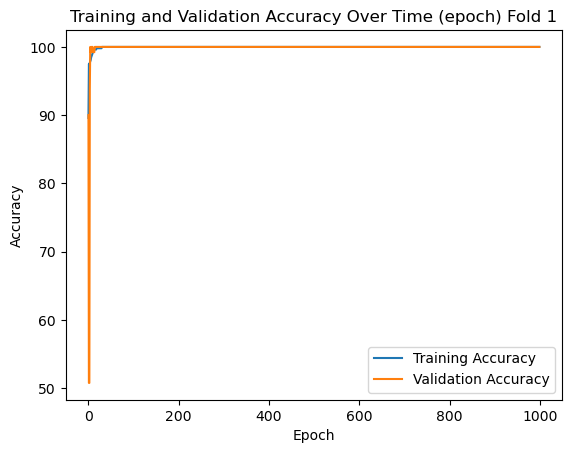

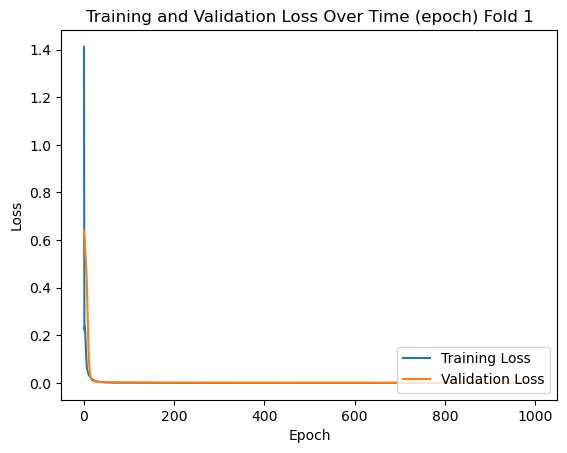

Exec Time : 82.43 seconds

---- Train Set ----
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 250
False Positive : 4
False Negative : 9
True Negative : 256

Class False Evaluation
- Precision : 98.425 %
- Recall : 96.525 %
- F1 : 0.97466

Class True Evaluation
- Precision : 96.604 %
- Recall : 98.462 %
- F1 : 0.97524

Combined Evaluation
- Accuracy : 97.495 %
- Precision : 97.514 %
- Recall : 97.493 %
- F1 : 0.97503
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Train, 97.495, 97.514, 97.493, 0.97503, 98.425, 96.525, 0.97466, 96.604, 98.462, 0.97524, 
Confusion Matrix Scikit-learn: 
[[256   4]
 [  9 250]]


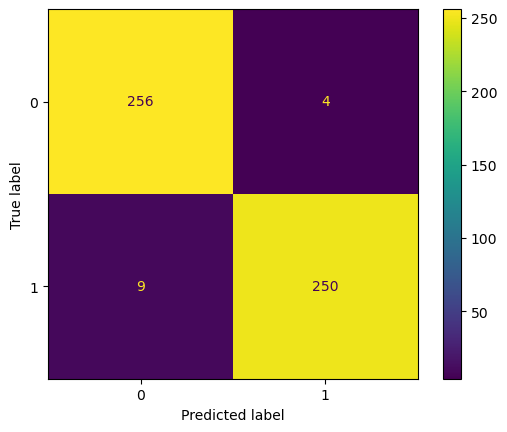


---- Validation Set ----
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 64
False Positive : 0
False Negative : 0
True Negative : 66

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[66  0]
 [ 0 64]]


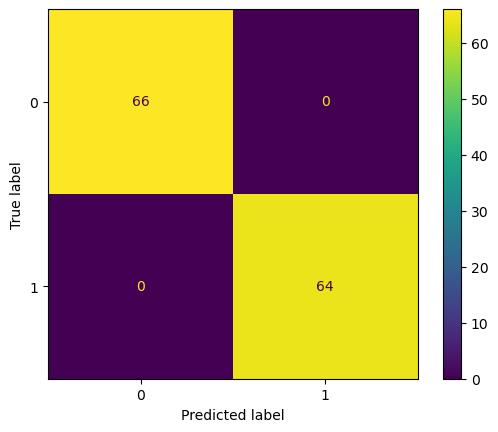


---- Test Set ----
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 40
False Positive : 1
False Negative : 7
True Negative : 45

Class False Evaluation
- Precision : 97.561 %
- Recall : 85.106 %
- F1 : 0.90909

Class True Evaluation
- Precision : 86.538 %
- Recall : 97.826 %
- F1 : 0.91837

Combined Evaluation
- Accuracy : 91.398 %
- Precision : 92.05 %
- Recall : 91.466 %
- F1 : 0.91757
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold1 Test, 91.398, 92.05, 91.466, 0.91757, 97.561, 85.106, 0.90909, 86.538, 97.826, 0.91837, 
93
93
Confusion Matrix Scikit-learn: 
[[45  1]
 [ 7 40]]


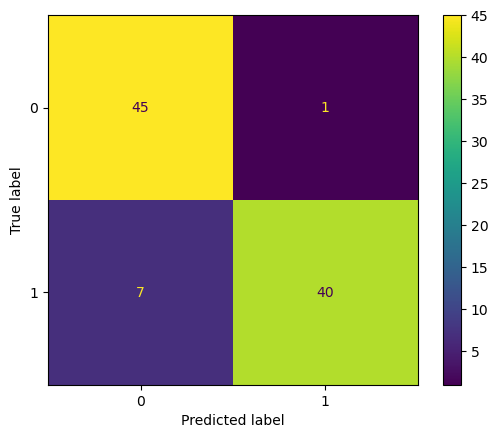

--- FOLD 2 ----
Multiclass Classification Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2
Using cuda
Saving after new best accuracy : 50.0
Saving after new best accuracy : 99.23076923076923
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0031761944701429456, Validation Loss : 0.0010340315056964755
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.000989999189187074, Validation Loss : 0.00034172949381172657
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0005049825722380774, Validation Loss : 0.0001810931571526453
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0003126332785541308, Validation Loss : 0.00011555862874956802
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00021470861247507855, Validation Loss : 8.143761078827083e-05
-- Epoch 300, Train_Accuracy : 100.0, Validation Accu

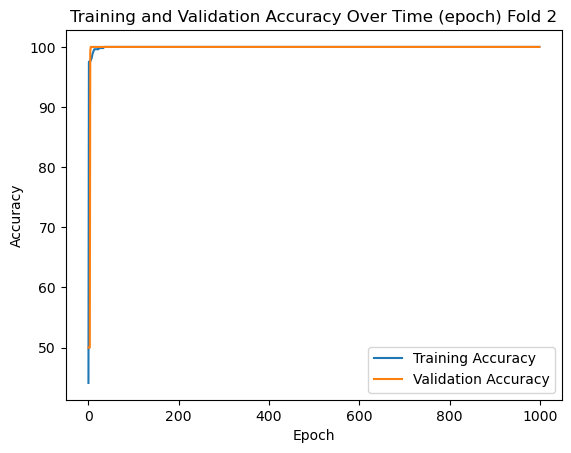

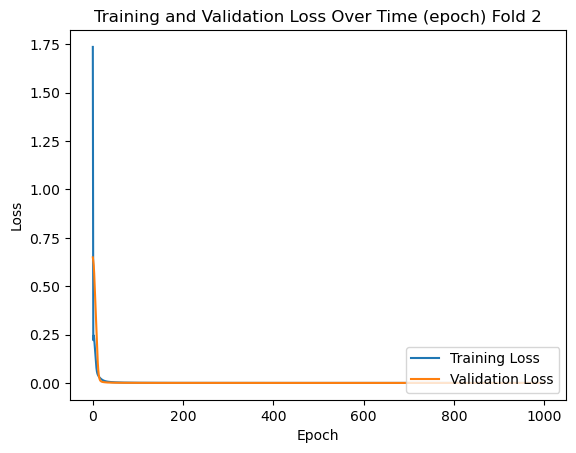

Exec Time : 79.27 seconds

---- Train Set ----
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 251
False Positive : 4
False Negative : 7
True Negative : 257

Class False Evaluation
- Precision : 98.431 %
- Recall : 97.287 %
- F1 : 0.97856

Class True Evaluation
- Precision : 97.348 %
- Recall : 98.467 %
- F1 : 0.97905

Combined Evaluation
- Accuracy : 97.881 %
- Precision : 97.89 %
- Recall : 97.877 %
- F1 : 0.97883
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Train, 97.881, 97.89, 97.877, 0.97883, 98.431, 97.287, 0.97856, 97.348, 98.467, 0.97905, 
Confusion Matrix Scikit-learn: 
[[257   4]
 [  7 251]]


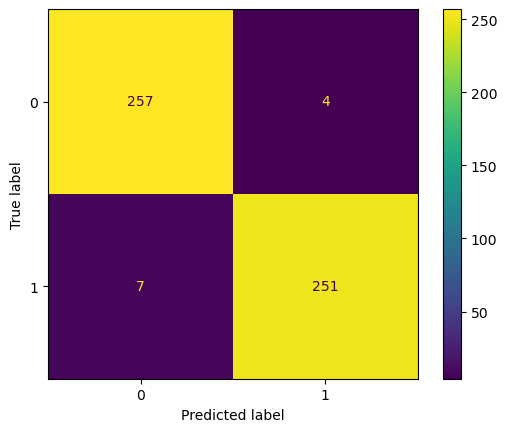


---- Validation Set ----
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 65
False Positive : 0
False Negative : 0
True Negative : 65

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[65  0]
 [ 0 65]]


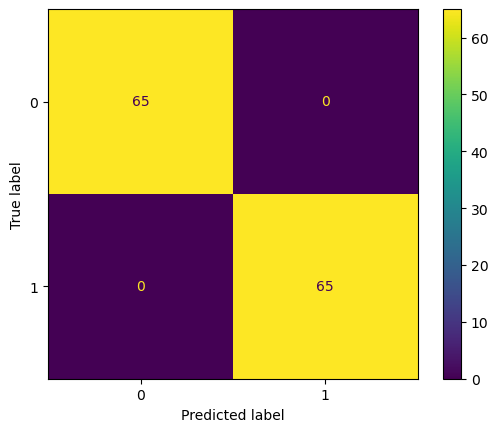


---- Test Set ----
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 41
False Positive : 1
False Negative : 6
True Negative : 45

Class False Evaluation
- Precision : 97.619 %
- Recall : 87.234 %
- F1 : 0.92135

Class True Evaluation
- Precision : 88.235 %
- Recall : 97.826 %
- F1 : 0.92784

Combined Evaluation
- Accuracy : 92.473 %
- Precision : 92.927 %
- Recall : 92.53 %
- F1 : 0.92728
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold2 Test, 92.473, 92.927, 92.53, 0.92728, 97.619, 87.234, 0.92135, 88.235, 97.826, 0.92784, 
93
93
Confusion Matrix Scikit-learn: 
[[45  1]
 [ 6 41]]


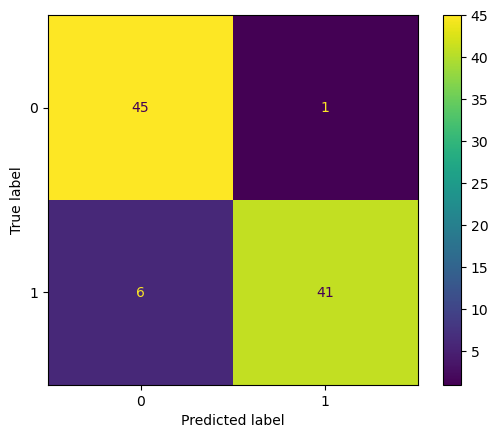

--- FOLD 3 ----
Multiclass Classification Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3
Using cuda
Saving after new best accuracy : 60.76923076923077
Saving after new best accuracy : 100.0
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.002900575884268619, Validation Loss : 0.0009606259409338236
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.0009166538584395312, Validation Loss : 0.0004107290005777031
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.000469762602733681, Validation Loss : 0.0002638480218593031
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00029129825543350307, Validation Loss : 0.00019657764642033726
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.00020019956536998507, Validation Loss : 0.00015763225383125246
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 100.0, Train Loss : 0.000146804

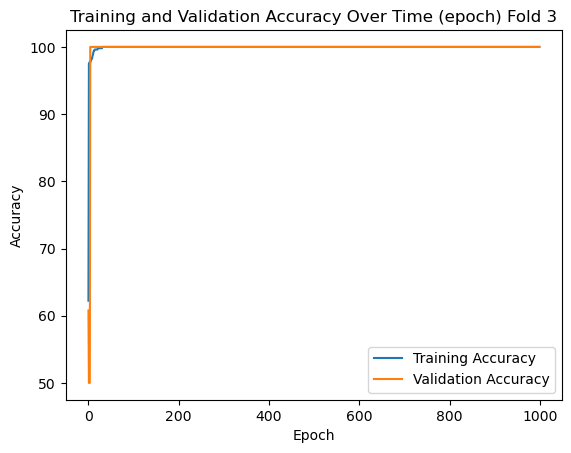

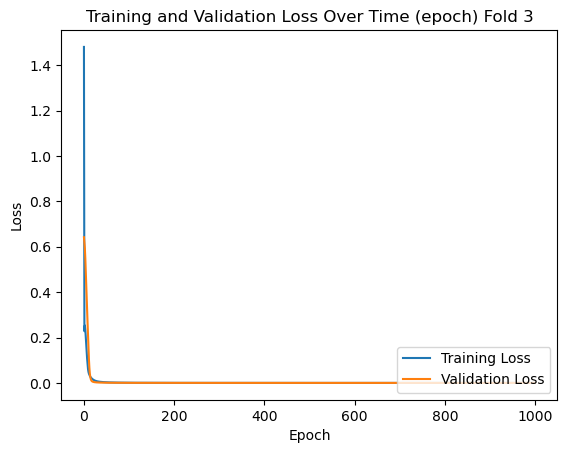

Exec Time : 79.82 seconds

---- Train Set ----
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 245
False Positive : 2
False Negative : 13
True Negative : 259

Class False Evaluation
- Precision : 99.19 %
- Recall : 94.961 %
- F1 : 0.9703

Class True Evaluation
- Precision : 95.221 %
- Recall : 99.234 %
- F1 : 0.97186

Combined Evaluation
- Accuracy : 97.11 %
- Precision : 97.205 %
- Recall : 97.097 %
- F1 : 0.97151
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Train, 97.11, 97.205, 97.097, 0.97151, 99.19, 94.961, 0.9703, 95.221, 99.234, 0.97186, 
Confusion Matrix Scikit-learn: 
[[259   2]
 [ 13 245]]


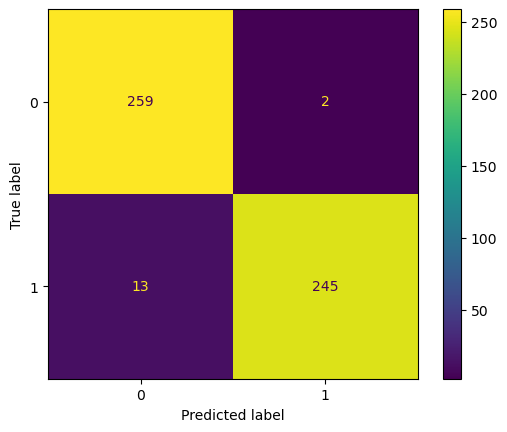


---- Validation Set ----
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 65
False Positive : 0
False Negative : 0
True Negative : 65

Class False Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Class True Evaluation
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0

Combined Evaluation
- Accuracy : 100.0 %
- Precision : 100.0 %
- Recall : 100.0 %
- F1 : 1.0
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Validation, 100.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 100.0, 100.0, 1.0, 
Confusion Matrix Scikit-learn: 
[[65  0]
 [ 0 65]]


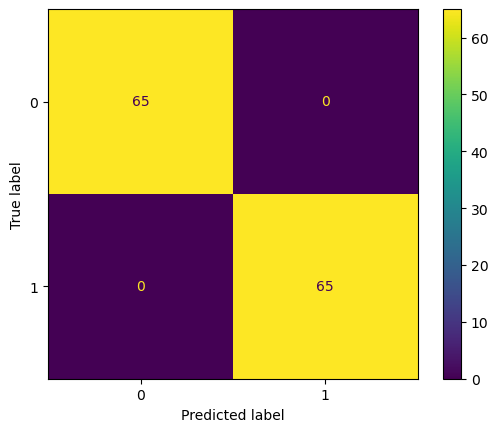


---- Test Set ----
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 10
True Negative : 46

Class False Evaluation
- Precision : 100.0 %
- Recall : 78.723 %
- F1 : 0.88095

Class True Evaluation
- Precision : 82.143 %
- Recall : 100.0 %
- F1 : 0.90196

Combined Evaluation
- Accuracy : 89.247 %
- Precision : 91.071 %
- Recall : 89.362 %
- F1 : 0.90208
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold3 Test, 89.247, 91.071, 89.362, 0.90208, 100.0, 78.723, 0.88095, 82.143, 100.0, 0.90196, 
93
93
Confusion Matrix Scikit-learn: 
[[46  0]
 [10 37]]


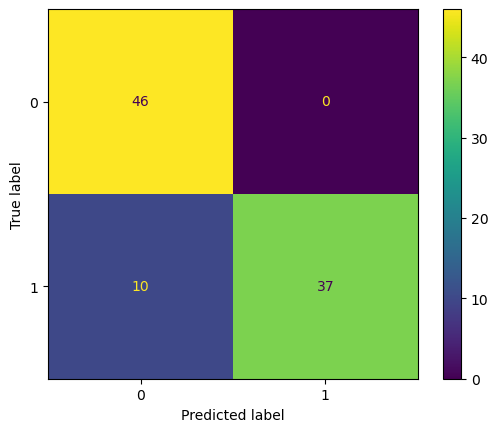

--- FOLD 4 ----
Multiclass Classification Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4
Using cuda
Saving after new best accuracy : 50.0
Saving after new best accuracy : 96.92307692307692
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 96.92307692307692, Train Loss : 0.00099963451793883, Validation Loss : 0.2389315515756607
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 96.92307692307692, Train Loss : 0.0003732475779543165, Validation Loss : 0.25186824798583984
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 96.92307692307692, Train Loss : 0.00020583951300068293, Validation Loss : 0.26290130615234375
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 96.92307692307692, Train Loss : 0.00013320913330971962, Validation Loss : 0.27188706398010254
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 96.92307692307692, Train Loss : 9.432483011551085e-05, Validation Loss : 0.2794339060783386
-- Epoch 300, Train_Accuracy : 100.0, Validati

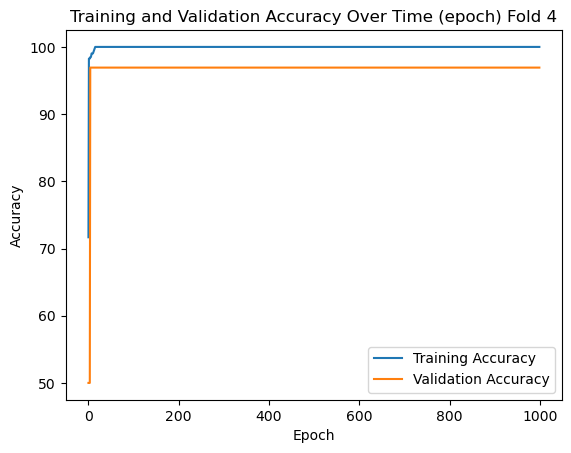

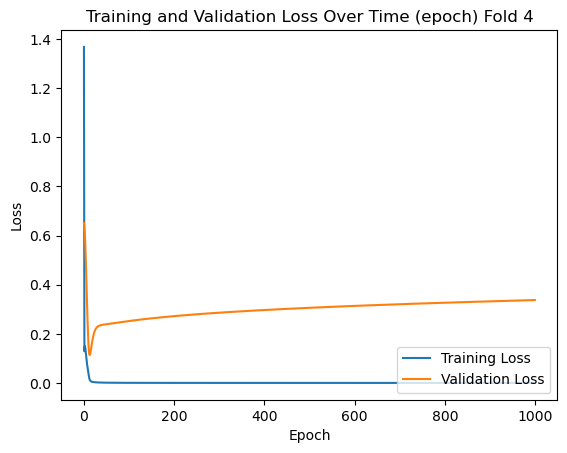

Exec Time : 79.59 seconds

---- Train Set ----
Predictions : torch.Size([519])
Binary Class Evaluation

True Positive : 249
False Positive : 1
False Negative : 9
True Negative : 260

Class False Evaluation
- Precision : 99.6 %
- Recall : 96.512 %
- F1 : 0.98031

Class True Evaluation
- Precision : 96.654 %
- Recall : 99.617 %
- F1 : 0.98113

Combined Evaluation
- Accuracy : 98.073 %
- Precision : 98.127 %
- Recall : 98.064 %
- F1 : 0.98095
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Train, 98.073, 98.127, 98.064, 0.98095, 99.6, 96.512, 0.98031, 96.654, 99.617, 0.98113, 
Confusion Matrix Scikit-learn: 
[[260   1]
 [  9 249]]


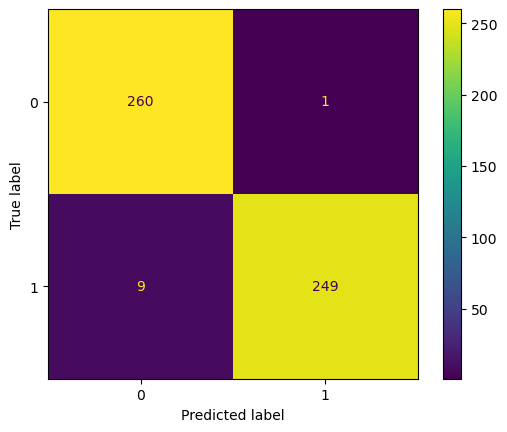


---- Validation Set ----
Predictions : torch.Size([130])
Binary Class Evaluation

True Positive : 62
False Positive : 1
False Negative : 3
True Negative : 64

Class False Evaluation
- Precision : 98.413 %
- Recall : 95.385 %
- F1 : 0.96875

Class True Evaluation
- Precision : 95.522 %
- Recall : 98.462 %
- F1 : 0.9697

Combined Evaluation
- Accuracy : 96.923 %
- Precision : 96.968 %
- Recall : 96.923 %
- F1 : 0.96945
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Validation, 96.923, 96.968, 96.923, 0.96945, 98.413, 95.385, 0.96875, 95.522, 98.462, 0.9697, 
Confusion Matrix Scikit-learn: 
[[64  1]
 [ 3 62]]


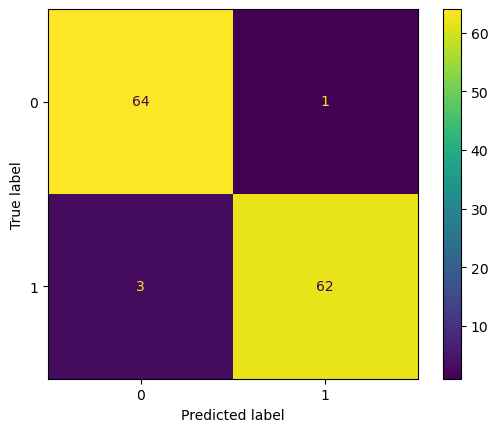


---- Test Set ----
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 37
False Positive : 0
False Negative : 10
True Negative : 46

Class False Evaluation
- Precision : 100.0 %
- Recall : 78.723 %
- F1 : 0.88095

Class True Evaluation
- Precision : 82.143 %
- Recall : 100.0 %
- F1 : 0.90196

Combined Evaluation
- Accuracy : 89.247 %
- Precision : 91.071 %
- Recall : 89.362 %
- F1 : 0.90208
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold4 Test, 89.247, 91.071, 89.362, 0.90208, 100.0, 78.723, 0.88095, 82.143, 100.0, 0.90196, 
93
93
Confusion Matrix Scikit-learn: 
[[46  0]
 [10 37]]


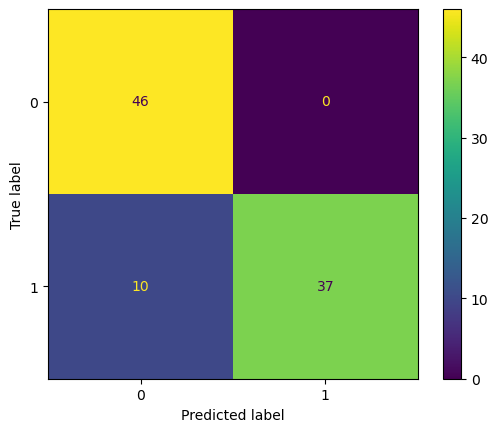

--- FOLD 5 ----
Multiclass Classification Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5
Using cuda
Saving after new best accuracy : 93.02325581395348
-- Epoch 50, Train_Accuracy : 100.0, Validation Accuracy : 89.14728682170542, Train Loss : 0.0005565059218497481, Validation Loss : 0.4448257386684418
-- Epoch 100, Train_Accuracy : 100.0, Validation Accuracy : 89.92248062015504, Train Loss : 0.000212916858799872, Validation Loss : 0.4760233163833618
-- Epoch 150, Train_Accuracy : 100.0, Validation Accuracy : 89.92248062015504, Train Loss : 0.00011788287247327389, Validation Loss : 0.4975331723690033
-- Epoch 200, Train_Accuracy : 100.0, Validation Accuracy : 89.92248062015504, Train Loss : 7.634919666088535e-05, Validation Loss : 0.5142326354980469
-- Epoch 250, Train_Accuracy : 100.0, Validation Accuracy : 89.92248062015504, Train Loss : 5.393432888922689e-05, Validation Loss : 0.5279870629310608
-- Epoch 300, Train_Accuracy : 100.0, Validation Accuracy : 89.92248062015504, Train Lo

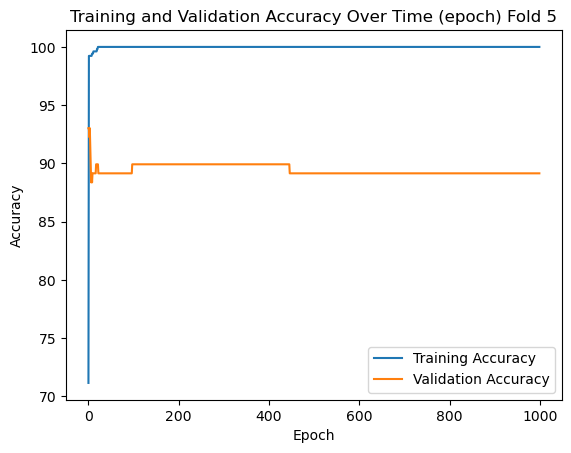

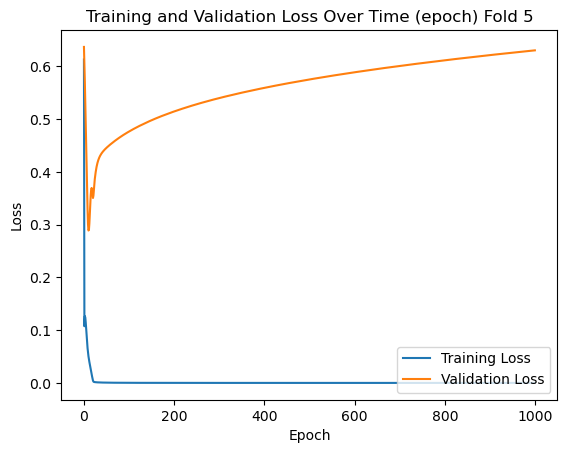

Exec Time : 79.98 seconds

---- Train Set ----
Predictions : torch.Size([520])
Binary Class Evaluation

True Positive : 256
False Positive : 1
False Negative : 3
True Negative : 260

Class False Evaluation
- Precision : 99.611 %
- Recall : 98.842 %
- F1 : 0.99225

Class True Evaluation
- Precision : 98.859 %
- Recall : 99.617 %
- F1 : 0.99237

Combined Evaluation
- Accuracy : 99.231 %
- Precision : 99.235 %
- Recall : 99.229 %
- F1 : 0.99232
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Train, 99.231, 99.235, 99.229, 0.99232, 99.611, 98.842, 0.99225, 98.859, 99.617, 0.99237, 
Confusion Matrix Scikit-learn: 
[[260   1]
 [  3 256]]


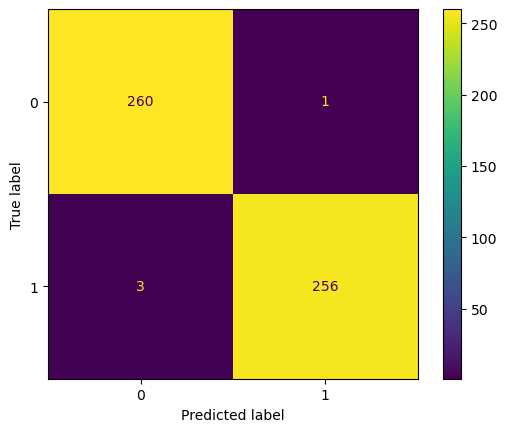


---- Validation Set ----
Predictions : torch.Size([129])
Binary Class Evaluation

True Positive : 60
False Positive : 5
False Negative : 4
True Negative : 60

Class False Evaluation
- Precision : 92.308 %
- Recall : 93.75 %
- F1 : 0.93023

Class True Evaluation
- Precision : 93.75 %
- Recall : 92.308 %
- F1 : 0.93023

Combined Evaluation
- Accuracy : 93.023 %
- Precision : 93.029 %
- Recall : 93.029 %
- F1 : 0.93029
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Validation, 93.023, 93.029, 93.029, 0.93029, 92.308, 93.75, 0.93023, 93.75, 92.308, 0.93023, 
Confusion Matrix Scikit-learn: 
[[60  5]
 [ 4 60]]


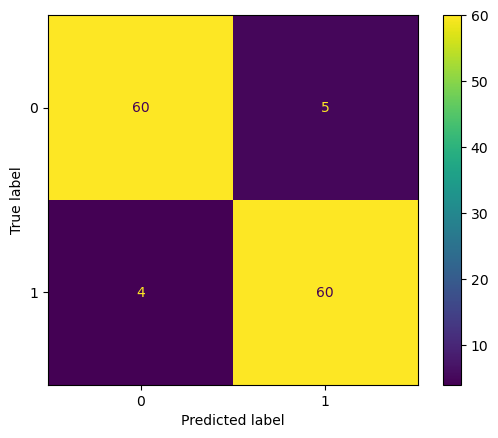


---- Test Set ----
Predictions : torch.Size([93])
Binary Class Evaluation

True Positive : 43
False Positive : 2
False Negative : 4
True Negative : 44

Class False Evaluation
- Precision : 95.556 %
- Recall : 91.489 %
- F1 : 0.93478

Class True Evaluation
- Precision : 91.667 %
- Recall : 95.652 %
- F1 : 0.93617

Combined Evaluation
- Accuracy : 93.548 %
- Precision : 93.611 %
- Recall : 93.571 %
- F1 : 0.93591
- Average Confidence : 100.0 %
Model, Combined,,,,False,,,True,,,
Twitter15-TF_ResNet10_CNN_RoBERTa_Finetuned_Fold5 Test, 93.548, 93.611, 93.571, 0.93591, 95.556, 91.489, 0.93478, 91.667, 95.652, 0.93617, 
93
93
Confusion Matrix Scikit-learn: 
[[44  2]
 [ 4 43]]


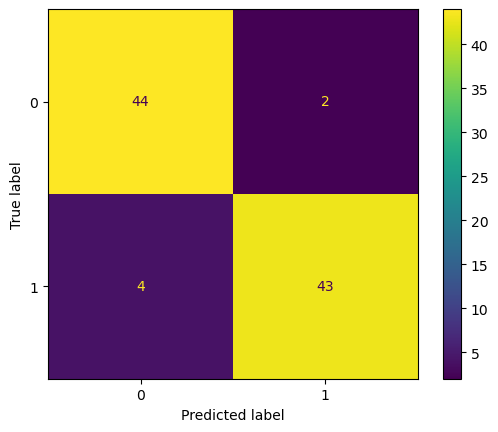

In [14]:
for i, (train_index, test_index) in enumerate(kf.split(for_cv_vectors, for_cv_labels)):
    print(f"--- FOLD {i+1} ----")
    train_vectors = for_cv_vectors[train_index]
    train_labels = for_cv_labels[train_index]
    val_vectors = for_cv_vectors[test_index]
    val_labels = for_cv_labels[test_index]
    
    model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}_Fold{i+1}"
    start = time.time()
    print(f"Multiclass Classification {model_name}")
    model = ResNetClassifier(CNNResNet10(n_output=2), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
    model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
                    torch.Tensor(train_labels),
                    torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
                    torch.Tensor(val_labels),
                    saves=model_name,
                    n_iter=1000,
                    batch_size=512,
                    fold=i+1)
    print(f"Exec Time : {round(time.time() - start, 2)} seconds")

    model.load_pretrained(f"../../data/models/cross-validation/{model_name}.pth")

    print("\n---- Train Set ----")
    preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(train_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Train"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(train_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Validation Set ----")
    preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(val_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Validation"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(val_labels)
    predictions=np.array(preds)
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

    print("\n---- Test Set ----")
    preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
    print(f"Predictions : {preds.shape}")

    preds = preds.cpu().numpy()

    conf_mat = ConfusionMatrix(
        labels=np.array(test_labels),
        predictions=np.array(preds),
        binary=True,
        model_name=f"{model_name} Test"
    )
    conf_mat.evaluate(classes=labels_str)

    labels=np.array(test_labels)
    predictions=np.array(preds)
    print(len(labels))
    print(len(predictions))
    cm = confusion_matrix(labels, predictions, labels=[0,1])
    print(f'Confusion Matrix Scikit-learn: \n{cm}')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot()
    plt.show()

In [15]:
# model_name = f"{dataset_name}_ResNet18_CNN_{unique_name}"
# start = time.time()
# print(f"Multiclass Classification {model_name}")
# model = ResNetClassifier(CNNResNet18(n_output=4), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# model_name = f"{dataset_name}_ResNet10_CNN_{unique_name}"
# start = time.time()
# print(f"Multiclass Classification {model_name}")
# model = ResNetClassifier(CNNResNet10(n_output=4), train_vectors.shape[1], n_output=2, criterion=nn.CrossEntropyLoss, n_features=16, model_type="cnn") #, device="cpu")
# model.train_eval(torch.Tensor(train_vectors.reshape(train_vectors.shape[0], 24, 32)),
#                 torch.Tensor(train_labels),
#                 torch.Tensor(val_vectors.reshape(val_vectors.shape[0], 24, 32)),
#                 torch.Tensor(val_labels),
#                 saves=model_name,
#                 n_iter=1000,
#                 batch_size=1024)
# print(f"Exec Time : {round(time.time() - start, 2)} seconds")

# model.load_pretrained(f"../../data/models/{model_name}.pth")

# print("\n---- Train Set ----")
# preds = model.predict(train_vectors.reshape(train_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(train_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Train"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(train_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Validation Set ----")
# preds = model.predict(val_vectors.reshape(val_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(val_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Validation"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(val_labels)
# predictions=np.array(preds)
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()

# print("\n---- Test Set ----")
# preds = model.predict(test_vectors.reshape(test_vectors.shape[0], 1, 24, 32))
# print(f"Predictions : {preds.shape}")

# preds = preds.cpu().numpy()

# conf_mat = ConfusionMatrix(
#     labels=np.array(test_labels),
#     predictions=np.array(preds),
#     binary=True,
#     model_name=f"{model_name} Test"
# )
# conf_mat.evaluate(classes=labels_str)

# labels=np.array(test_labels)
# predictions=np.array(preds)
# print(len(labels))
# print(len(predictions))
# cm = confusion_matrix(labels, predictions, labels=[0,1])
# print(f'Confusion Matrix Scikit-learn: \n{cm}')
# disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
# disp.plot()
# plt.show()